In [1]:
from io import open
from matplotlib import pyplot as plt
import math
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from json import loads
import unicodedata

In [2]:
with open('../custom-data/names.json', encoding='utf-8') as f:
	category_lines = loads(f.read().lower())
all_letters = sorted({c for names in category_lines.values() for name in names for c in name})
n_letters = len(all_letters)
n_categories = len(category_lines)
all_categories = list(category_lines.keys())

In [4]:
def letterToIndex(letter):
    return all_letters.index(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [7]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [8]:
criterion = nn.NLLLoss()

In [9]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [13]:
n_iters = 100000
print_every = 5000
plot_every = 1000
current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s / %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% 0.2423 espino / spanish ✓
10000 10% 0.0089 shimuzu / japanese ✓
15000 15% 1.0849 dalach / czech ✗ (irish)
20000 20% 1.7319 montgomery / french ✗ (english)
25000 25% 0.4475 johnstone / scottish ✓
30000 30% 2.0172 baumann / russian ✗ (german)
35000 35% 0.4850 raske / dutch ✓
40000 40% 0.0350 schrijnemakers / dutch ✓
45000 45% 0.0005 takudome / japanese ✓


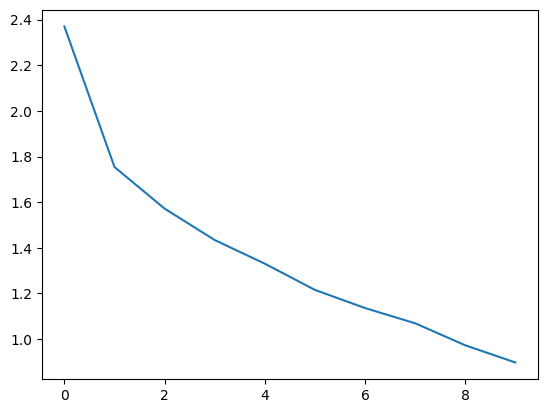

In [11]:
plt.plot(torch.tensor(all_losses).view(-1, 10).mean(dim=1))